
# PDF Feature Extraction for Classification
In this notebook, we aim to extract key features from PDF files in order to classify them into two categories: "document" or "powerpoint". This involves analyzing various attributes of the PDFs, such as the average word count, page dimensions, and rotation. We use a combination of `PyPDF2`, `pytesseract`, and `pdf2image` to extract these features.

## Overview of the Approach
The classification logic is based on certain features that can help differentiate between typical documents and presentations. The extracted features will be used to train a machine learning model for classification purposes. This approach is necessary because the metadata available from PDFs does not provide sufficient information about the type of content, especially since most of the PDFs are scanned images.

The features we will extract are:
1. **Average Word Count**: We calculate the average word count for the first 10 pages of each PDF. Documents are likely to have more words compared to presentations.
2. **Page Rotation**: We check if all the pages are rotated. Presentations are often in landscape mode, while documents are typically in portrait mode.
3. **Page Dimensions**: We measure the width and height of the pages, which can provide insight into the type of document.

The following sections describe each step in detail, along with the code used for implementation.




## Imports and Setup
First, we import the necessary libraries for feature extraction. These libraries include:
- `os`: For handling file paths and iterating over files.
- `PyPDF2`: For extracting metadata from PDF files.
- `pytesseract`: For performing OCR (Optical Character Recognition) on images.
- `pdf2image`: For converting PDF pages to images.
- `PIL` (Pillow): For working with images.
- `pandas`: For organizing the extracted data.


In [9]:
# Import necessary libraries
import os
import PyPDF2
import pytesseract
from pdf2image import convert_from_path
import pandas as pd


## Feature Extraction Function
The main function, `extract_pdf_features`, combines the metadata extraction and the OCR word count extraction to produce a set of features for each PDF:
- **Number of Pages** (`num_pages`)
- **Average Width** (`average_width`)
- **Average Height** (`average_height`)
- **All Pages Rotated** (`all_pages_rotated`)
- **Average Word Count** (`average_word_count`)



In [10]:
def extract_pdf_features(file_path):
    features = {}
    try:
        # Open the PDF file
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            num_pages = len(reader.pages)
            features['num_pages'] = num_pages

            # Initialize lists to store page dimensions and rotations
            widths = []
            heights = []
            rotations = []
            all_pages_rotated = True

            # Iterate over each page to extract dimensions and rotation
            for page_number, page in enumerate(reader.pages):
                mediabox = page.mediabox
                width = int(mediabox.width)
                height = int(mediabox.height)
                widths.append(width)
                heights.append(height)

                rotation = page.get('/Rotate')
                if rotation is None:
                    rotation = 0
                rotations.append(rotation)
                if rotation == 0:
                    all_pages_rotated = False  # If any page is not rotated

            # Calculate average width and height as integers
            features['average_width'] = int(sum(widths) / len(widths))
            features['average_height'] = int(sum(heights) / len(heights))
            features['all_pages_rotated'] = int(all_pages_rotated)

        # Extract text from the first 10 pages using OCR
        # Convert PDF pages to images
        images = convert_from_path(file_path, first_page=1, last_page=min(10, num_pages))

        total_words = 0
        for image in images:
            # Perform OCR using pytesseract
            text = pytesseract.image_to_string(image)
            # Count words
            word_count = len(text.split())
            total_words += word_count

        average_word_count = int(total_words / len(images)) if images else 0
        features['average_word_count'] = average_word_count

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        # You can choose to handle the error differently or re-raise it
        features = None

    return features



## Iterating Over PDF Files
We iterate over all PDFs present in the `data` directory, which contains subdirectories for both "documents" and "powerpoints". For each PDF, we extract its features and store them in a list.

The features are eventually organized into a pandas DataFrame for easy analysis and visualization.


In [11]:
# Define the data directories
data_dir = 'data'
categories = ['documents', 'powerpoints']
pdf_features = []

# Iterate over each category and extract features
for category in categories:
    category_dir = os.path.join(data_dir, category)
    for i, filename in enumerate(os.listdir(category_dir)):
        if filename.endswith('.pdf'):
            file_path = os.path.join(category_dir, filename)
            print(f"Processing file {i+1}: {file_path}")
            features = extract_pdf_features(file_path)
            features['category'] = category
            features['filename'] = filename
            pdf_features.append(features)

Processing file 1: data/documents/9DoGDiyCkjC5y3VxuEQDwbDtpo4gk7.pdf
Processing file 2: data/documents/jcuH2t7vPM6O6iHL7ATZpvTd7mQ7V5.pdf
Processing file 3: data/documents/FxJWfc7RHRoIxjobCy3sj9NeTeEkje.pdf
Processing file 4: data/documents/BUbIVts2KCnlZ6H9i5tv2gsLJElX9q.pdf
Processing file 5: data/documents/EhNh77FZGrMPJ1GB8m0GEZXCdx6pvy.pdf
Processing file 6: data/documents/LZudSeYUm9fvwPOLhI5ljXJNmHEsLW.pdf
Processing file 7: data/documents/4uUeq4Da54oEi81HFcBp3YVze648h3.pdf
Processing file 8: data/documents/dRcbObnj9xcc5QCucWf1DpHArCYNtE.pdf
Processing file 9: data/documents/pErWd8019CtGK62WPMzagMmkH6U2Zm.pdf
Processing file 10: data/documents/6F47Rh2r9H8Bd7kEWW4djYWLEL8wcs.pdf
Processing file 11: data/documents/IV4yuy43WWXCwECkZhrL6rtcg1M6RT.pdf
Processing file 12: data/documents/GDa03YiPhydkaKPwMa3qjEmYNCIIU9.pdf
Processing file 13: data/documents/16djj5ADJpSyrEUsy0cquFioZpiiFB.pdf
Processing file 14: data/documents/oLpOm8vcjn89GvizG0QVqLlvVSN7Vd.pdf
Processing file 15: data/docu


## Creating a DataFrame for Analysis
After extracting features from all PDF files, we convert the list of feature dictionaries into a pandas DataFrame for easier analysis and visualization.


In [12]:
# Convert the list of features to a DataFrame
df_features = pd.DataFrame(pdf_features)

# Display the first few rows
df_features


,num_pages,average_width,average_height,all_pages_rotated,average_word_count,category,filename
0,201,595,842,0,308,documents,9DoGDiyCkjC5y3VxuEQDwbDtpo4gk7.pdf
1,2,594,841,0,476,documents,jcuH2t7vPM6O6iHL7ATZpvTd7mQ7V5.pdf
2,256,594,841,0,602,documents,FxJWfc7RHRoIxjobCy3sj9NeTeEkje.pdf
3,4,595,842,0,298,documents,BUbIVts2KCnlZ6H9i5tv2gsLJElX9q.pdf
4,51,595,842,0,304,documents,EhNh77FZGrMPJ1GB8m0GEZXCdx6pvy.pdf
...,...,...,...,...,...,...,...
143,11,1024,768,1,51,powerpoints,7dC5IpjZwcUvvONFjuIc3sKwkCvCGY.pdf
144,8,1024,724,1,46,powerpoints,XzflweMGe1RXZ67dIPznkWyWYuNVWQ.pdf
145,16,960,540,1,173,powerpoints,qHwY3ZER9KMo2gzWlC1A0PiasGv2rQ.pdf
146,13,1024,640,1,38,powerpoints,cVX1dwoTXlgY80iFOMw6yAEL2ns2zA.pdf


In [28]:
# Save the DataFrame to a CSV file
df_features.to_csv('data/csv/pdf_features.csv', index=False)



# PDF Classification Model Development

We will evaluate three different machine learning models and compare their performance:
1. Logistic Regression
2. Support Vector Machine (SVM)
3. Random Forest Classifier

The following sections describe each step in the process.



## Imports and Setup
We import the necessary libraries for preparing the dataset, training the models, and evaluating their performance.


In [43]:

# Import libraries for cross-validation and metrics evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Used for saving the model


## Data Preparation
We prepare the data for training by selecting the relevant features and splitting the dataset into training and testing sets.


In [40]:

# Load the features DataFrame (assuming it's already saved as df_features)
# In practice, you would load it from your previous extraction step or CSV
# df_features = pd.read_csv('data/csv/pdf_features.csv')

# Selecting only the relevant features for classification
X = df_features[['average_width', 'average_height', 'all_pages_rotated', 'average_word_count']]
y = df_features['category']  # Target labels (document or powerpoint)

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
X

,average_width,average_height,all_pages_rotated,average_word_count
0,595,842,0,308
1,594,841,0,476
2,594,841,0,602
3,595,842,0,298
4,595,842,0,304
...,...,...,...,...
143,1024,768,1,51
144,1024,724,1,46
145,960,540,1,173
146,1024,640,1,38



## Model Training
We train three different machine learning models:
1. **Logistic Regression**
2. **Support Vector Machine (SVM)**
3. **Random Forest Classifier**

We will evaluate their accuracy and performance to determine which model works best for this classification task.



### Logistic Regression
We start by training a Logistic Regression model and evaluating its performance on the test set.


Logistic Regression Model Evaluation:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

   documents       1.00      1.00      1.00        17
 powerpoints       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



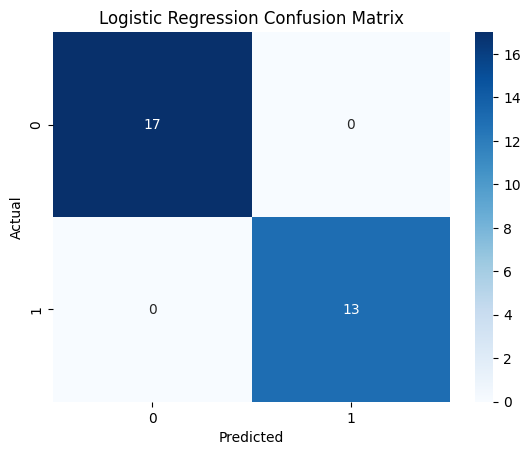

In [65]:

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print()
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Plotting the confusion matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### Support Vector Machine (SVM)
Next, we train an SVM model to classify the PDF files.


SVM Model Evaluation:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

   documents       1.00      1.00      1.00        17
 powerpoints       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



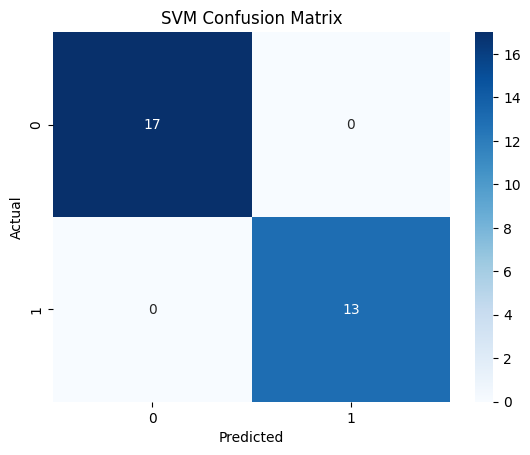

In [37]:

# Initialize the SVM model
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print()
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Plotting the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, cmap='Blues', fmt='g')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



### Random Forest Classifier
Finally, we train a Random Forest Classifier and evaluate its performance.


Random Forest Model Evaluation:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

   documents       1.00      1.00      1.00        17
 powerpoints       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



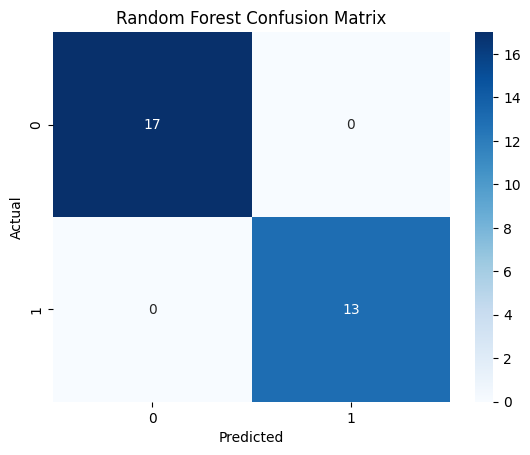

In [36]:

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print()
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Plotting the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Cross-Validation Setup
We use k-fold cross-validation (k=10) to evaluate the performance of the models.

We will compare the average accuracy across the folds and the consistency of each model to determine the best one.


In [74]:

from sklearn.model_selection import KFold

# Initialize cross-validation setup
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Perform cross-validation and store results
cross_val_results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    cross_val_results[model_name] = scores
    print(f"{model_name} Cross-Validation Results:")
    print(f"Accuracy Scores: {scores}")
    print(f"Mean Accuracy: {np.mean(scores):.4f}")
    print(f"Standard Deviation: {np.std(scores):.4f}")


Logistic Regression Cross-Validation Results:
Accuracy Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000
Standard Deviation: 0.0000
Support Vector Machine Cross-Validation Results:
Accuracy Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000
Standard Deviation: 0.0000
Random Forest Cross-Validation Results:
Accuracy Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000
Standard Deviation: 0.0000


### Conclusion: Choosing Logistic Regression

The cross-validation results for Logistic Regression, Support Vector Machine (SVM), and Random Forest all yielded a perfect mean accuracy of **1.0000** with a standard deviation of **0.0000** across 10 folds. This indicates that all three models were able to classify the data perfectly without any variability, suggesting that the dataset is linearly separable and relatively easy to classify.

Given the comparable performance, we chose **Logistic Regression** for several reasons:

- **Simplicity**: Logistic Regression is a simple and efficient model that provides a straightforward interpretation of feature coefficients. Its ease of implementation and interpretability makes it a preferred choice when the complexity of other models does not provide additional performance gains.

- **Low Computational Cost**: Logistic Regression is computationally less intensive compared to SVM and Random Forest, which can be advantageous for rapid prototyping and scenarios where computational resources are limited.

- **Baseline Model**: Logistic Regression is often used as a baseline model due to its linear nature and interpretability. Given that the dataset is linearly separable, Logistic Regression can achieve optimal performance without the need for the complexity introduced by ensemble models or kernel-based methods.

In summary, since all models achieved perfect accuracy, the **simplicity, interpretability, and efficiency** of Logistic Regression make it the most suitable choice for this classification task. It provides an ideal balance between performance and practicality without unnecessary model complexity.



## Model Training
We will train the Logistic Regression model using the entire dataset. 



In [69]:

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model on the entire dataset
log_reg.fit(X, y)

print("Model training complete.")

Model training complete.



## Saving the Model
After training, we save the model using `joblib` so that it can be used later in the RESTful API.


In [47]:

# Save the trained Logistic Regression model to a file
model_filepath = "pdf_classifier/models/logistic_regression_model.pkl"
joblib.dump(log_reg, model_filepath)

print(f"Model saved to {model_filepath}")


Model saved to pdf_classifier/models/logistic_regression_model.pkl
